<a href="https://colab.research.google.com/github/NYUExperimentalPhysics1-2021/labanalysis2-TNoiem4741/blob/main/Small_LabAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this assigmnent, you will add to existing code.** Each line you have to write has a numbered comment, so you won't miss one, CODE1, CODE2...CODE25

**If something doesn't work the way you think it should,** please email the Professor and the TAs for help. This notebook started as working code; we removed lines to create the assignment. This process might have introduced an unexpected error. 

As in other assignments, this first code block is meant to set things up. Below, modify the ```!git clone``` line so that the url points to your own data repository.



In [1]:
# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator

# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY
!git clone https://github.com/NYUExperimentalPhysics1-2021/lab2-data-repository-TNoiem4741

#this line makes sure you followed the direction above; if you see 20 copies of "you didn't change the directory to match your name!" that means you need to update the data repository name and clone again
#delete my data repository (use folder icon on the left) or you will get this message again
if os.path.isdir('lab2-data-repository-mgershow'):
  for i in range(20):
    print ("You didn't change the directory to match your name!")

Cloning into 'lab2-data-repository-TNoiem4741'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (422/422), done.
remote: Total 423 (delta 0), reused 418 (delta 0), pack-reused 0
Receiving objects: 100% (423/423), 121.75 MiB | 22.96 MiB/s, done.
Checking out files: 100% (392/392), done.


These functions are needed to load the data, check that the data is valid (as in there aren't wild jumps in amplitude or period that would be due to measurement malfunctions), and return the largest sequences of valid data. Not important to know how they work, just how to run them.

In [2]:
def findSlopeAndAmplitudeFiles (startdir):
  #(slopeFiles, amplitudeFiles) = findSlopeAndAmplitudeFiles(startdir)
  # input stardir: path to top level directory (e.g. data_repository/large bob)
  # output slopeFiles: dictionary with paths to slope files, key names are taken from directories under large bob
  #   e.g. if large bob has a directory 2mm, then
  #   slopeFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories
  # output amplitudeFiles: same as slopeFiles, but paths to all files ending _angle.txt
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  slopeFiles = dict()
  amplitudeFiles = dict()
  for entry in os.scandir(startdir):
    if (entry.is_dir):
      key = entry.name
      slopeFiles[key] = sorted(glob.glob(entry.path + '/**/*_slope.txt'))
      amplitudeFiles[key] = sorted(glob.glob(entry.path + '/**/*_angle.txt'))
      if (len(slopeFiles[key]) != len(amplitudeFiles[key])):
        print("Warning! " + key + " does not contain same number of slope and angle files")
  return (slopeFiles, amplitudeFiles)

# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no wild outliers)
# returns longest sequence of valid data
def sanityCheck(time, y, number):
  dt = np.diff(time)
  dly = np.diff(np.abs(np.log(y)))
  dn = np.diff(number)
  maxperiod = 5 #equivalent to 6 meter pendulum
  maxchange = np.log(1.5) #don't allow an INCREASE of more than 50%
  valid = ((dt > 0) & (dt < maxperiod) & (dly < maxchange) & (dn > 0) & (dn <= 2))
  (start,stop) = longestTrueSequence(valid)
  if start > 0:
    start = start+1
  time = time[start:stop+1]
  y = y[start:stop+1]
  number = number[start:stop+1]
  return(time,y,number)

# load slope and get longest valid sequence
# takes the absolute value of slope 
# inputs: filepath - path of the file
#         maxTime - optional, longest duration to load
# outputs: time - time of the crossing
#          slope - absolute value of slope at each crossing
#          number - index of crossing, should increase by 1 each step
def loadSlopeFile(filepath, maxTime = 10000000):
  time, slope, number = np.loadtxt(filepath, skiprows = 1, unpack=True)
  time,slope,number = sanityCheck(time,np.abs(slope),number)
  valid = time-time[0] <= maxTime
  time = time[valid]
  slope = slope[valid]
  number = number[valid]
  return (time,slope,number)

# load amplitude and get longest valid sequence
# inputs: filepath - path of the file
#         maxTime - optional, longest duration to load
# outputs: time - time of the crossing
#          amplitude - absolute value of amplitude fit to the complete ellipse centered on the crossing
#          number - index of crossing, should increase by 2 each step
def loadAmpltidueFile(filepath, maxTime = 10000000):
  time, theta, amplitude, minaxis, number = np.loadtxt(filepath, skiprows = 1, unpack = True)
  time,amplitude,number = sanityCheck(time,np.abs(amplitude),number)
  valid = time-time[0] <= maxTime
  time = time[valid]
  amplitude = amplitude[valid]
  number = number[valid]
  return (time, amplitude, number)

These functions do the equation fitting, and you should try to familiarize yourself with how fitting works. These will be used to fit your data to exponential and linear curves.

In [3]:
# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
def fitExponential(x,y):
  xx = x - np.min(x)
  yy = y / np.max(y)
  fitparams, *_ = scipy.optimize.curve_fit(lambda xdata, a, b : a*np.exp(b * xdata), xx, yy, (1, -1/max(xx)))
  a,b = fitparams
  a = a*np.max(y)*np.exp(-b*np.min(x))
  return (a,b, a*np.exp(b*x))

# fitting a line
# line is polynomial of degree 1
# two free parameters, the slope and the y intercept
# inputs: x,y - numpy arrays
# outputs: slope (m): fit value of slope
#          intercept (b): fit value of intercept (y(0))
#          fity: m*x + b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  slope = p[0]
  intercept = p[1]
  return (slope, intercept, slope*x + intercept)

The below block shows an example of how to load the data for the large bob. This will create two [dictionaries](https://physics.nyu.edu/pine/pymanual/html/chap3/chap3_arrays.html#dictionaries), ```largeSlope``` and ```largeAmplitude```, which contain the displacement as the key and the data from the text file as the value. In order to load the data, you will need to know the file structure of your repository and give the ```findSlopeAndAmplitudeFiles()``` function the proper path to the displacement folders. For example, ```'lab2-data-repository-mgershow/'``` is the top level folder and ```'large bob'``` is the next-level folder that contains all of the displacement folders ```'2mm'```, ```'3mm'```, ```'4mm'```, and so on.

In [4]:

#uncomment this line if you are also ready to analyze small bob data
smallSlope, smallAmplitude = findSlopeAndAmplitudeFiles('lab2-data-repository-TNoiem4741/Small bob')


## Energy vs time - individual traces and fits

For three distributed distances of the large bob from the plate (e.g. 3 mm, 6 mm, 9 mm)

1. Make a new figure
1. Make 2 subplots side by side.
1. In the left subplot, plot the **slope** vs. time since the start of the measurement (time - time[0]) of each dataset on the same graph. Make the [y-axis logarithmic](https://physics.nyu.edu/pine/pymanual/html/chap5/chap5_plot.html#logarithmic-plots). The data should look like a straight line
1. For each experiment you plotted, calculate an exponential fit to the data and store the lifetime (the fit gives you a and b in the equation $s = a e^{b t}$, and $\tau = -\frac{1}{b}$). Store the calculated lifetime in a list called slope_lifetime.
1. Title the plot with the mean and standard deviation of the lifetimes.
1. In the right subplot, do the same thing but with the **amplitude squared**


We've done a lot of this work for you - you will need to fill in the parts indicated by comments below

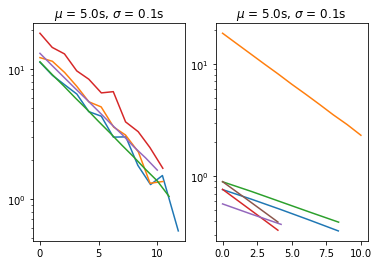

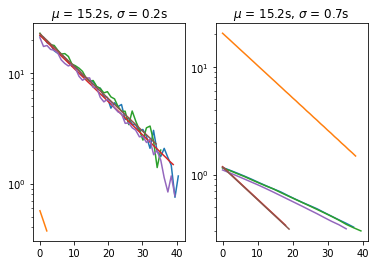

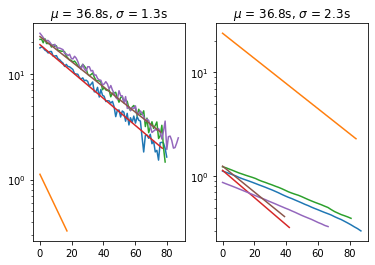

In [5]:
import statistics
for expt_set_dir in ["3mm", "6mm", "9mm"]: #replace with your own directory names
  slope_lifetime = []
  ampsq_lifetime = []
  plt.figure()
  plt.subplot(1, 2, 1)
  for file in smallSlope[expt_set_dir]:
    time, slope, number = loadSlopeFile(file)
    #CODE1: use plt.semilogy to make a plot of time-time[0] on the linear x-axis vs. slope on the logarithmic y-axis  
    plt.semilogy(time-time[0],slope,*_)
    a,b,*_ = fitExponential(time-time[0], slope)  #use *_ to discard unwanted return values (in this case the fit y-data)
    slope_lifetime.append(-1/b)#CODE2: modify this line to add -1/b (the fit lifetime) to the slope_lifetime list
  mu = statistics.mean(slope_lifetime)
  #CODE3: calculate the mean of slope_lifetime
  sigma = np.std(slope_lifetime, ddof=1) #calculates the standard deviation using N-1 in the deonminator
  plt.title (r'$\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu, sigma))
  
  
  plt.subplot(1, 2, 2)
  for file in smallAmplitude[expt_set_dir]:
    time, amp, number = loadAmpltidueFile(file)
    #CODE4: use plt.semilogy to make a plot of time-time[0] on the linear x-axis vs. amplitude SQUARED on the logarithmic y-axis 
    plt.semilogy(time-time[0],amp,*_)  
    a,b,*_ = fitExponential(time-time[0], amp)
    #CODE5: complete to calculate the exponential fit of amp squared to time-time[0] hint: see very similar code above! 
    ampsq_lifetime.append(-1/b)
  mu = statistics.mean(slope_lifetime)
  #CODE6: calculate the mean of slope_lifetime
  sigma = np.std(ampsq_lifetime, ddof=1)
  plt.title (r'$\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu, sigma))


##QUESTIONS - answer below 

1. What evidence do you have that the energy decays exponentially (or that it does not)? **when the lab was being done the data when plotted by the board, had an exponetial fit.**
2. Are the slope and amplitude measurements consistent with each other?
**They are close, but the slope is mor enoisey and in such more inconsistency in the expontial fit og the graph.**
3. Based on a visual examination of the graphs, which measurement of the energy of the bob has more noise (slope or amplitude squared)
**The slope does since it fluxates more than the lines of the amp square.**
4. Based on the standard deviation of the lifetime measurements, which measurement of the lifetime (fit to slope or fit to amplitude squared) has less experimental error?
**In this case it seems that the standard deviatoion of the left graphs show less experimental error.**
5. If you find that these results disagree unexpectedly, look at the x-axes of the plots. Do the slope and amplitude data cover the same time ranges? The loading function automatically tries to discard noisy data. Does this explain why the slope measurements are shorter than the amplitude measurements?
**They dont, and that is due to thhere being more noise on the slope graph causing more of the data to disappear.**


## Energy vs time - fixed time range

Copy and paste your solution in the code box below. Let's modify it a little so that each experiment covers roughly the same time range within an experimental condition.

The load commands take an optional argument, maxTime that cuts the length of the loaded data to that time range (or shorter if the full range isn't available). Let's redo the excercise above, limiting the time range to 1.5 lifetimes. 

We have to iterate in a slightly different way, so we've written the for loop structure for you - it's your job to fill in the rest

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3

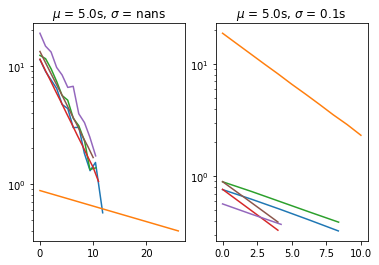

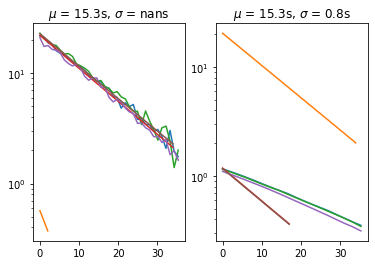

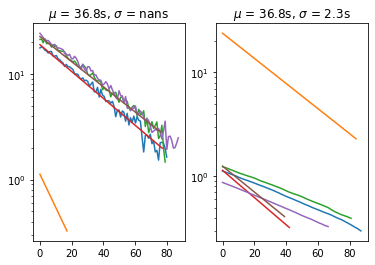

In [7]:
expt_set_dirs =  ["3mm", "6mm", "9mm"] #replace with your own directory names
lifetime = [5, 15.2, 36.8] #replace with the lifetimes you measured above
for i in range(3):
  expt_set_dir = expt_set_dirs[i]
  slope_lifetime = []
  ampsq_lifetime = []
  plt.figure()
  plt.subplot(1, 2, 1)
  for file in smallSlope[expt_set_dir]:
    time, slope, number = loadSlopeFile(file, lifetime[i]*((4/3)**3))
    #CODE7: three lines of code that do an exponential fit, semilog plot, and add lifetime to list
    plt.semilogy(time-time[0],slope,*_)
    a,b,*_ = fitExponential(time-time[0], slope)  
    slope_lifetime.append(-1/b)
  #CODE8: two lines of code that calculate mean and standard deviation
  mu = statistics.mean(slope_lifetime)
  sigma = np.std(ampsq_lifetime, ddof=1) 
  plt.title (r'$\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu, sigma))

  plt.subplot(1, 2, 2)
  for file in smallAmplitude[expt_set_dir]:
    time, amp, number = loadAmpltidueFile(file, lifetime[i]*((4/3)**3))
    #CODE9: three lines of code that do an exponential fit, semilog plot, and add lifetime to list
    plt.semilogy(time-time[0],amp,*_)  
    a,b,*_ = fitExponential(time-time[0], amp)
    ampsq_lifetime.append(-1/b)
  #CODE10: two lines of code that calculate mean and standard deviation
  mu = statistics.mean(slope_lifetime)
  sigma = np.std(ampsq_lifetime, ddof=1)
  plt.title (r'$\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu, sigma))


##QUESTIONS - answer below
1. Did shortenting the time range change which method of lifetime measurement had less error?
**Yes since it showed nans for the left meaning that the data when the time range is set for both then the data is not sufficent enough to provide a proper result. In other words, bad noisey data in the left graphs cause it to be insufficent for analyzation of the experiment.**

## Energy vs time - let's look again

If your data looks like mine (and it may not!), there's a bit of a paradox, the slope measurement looks "noisier" - the energy bounces around a lot more from swing to swing - but the lifetime measurement is more consistent from experiment to experiment. Let's have one last look.

Copy your entire code block from above. Make one change: instead of plotting slope or amplitude^2 vs. time, plot slope/a (or amplitude^2/a) vs. time, where a is the fit parameter for slope(t = 0) from your exponential fits. This will make curves with the same lifetimes look identical. 

Hint: change the order, so you first calculate the fit, then make the plot, like this

```
  a,b,*_ = fitExponential(time-time[0], slope) 
  plt.semilogy(time-time[0], slope/a)
```

double hint: this hint may give away an answer to a previous question


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3

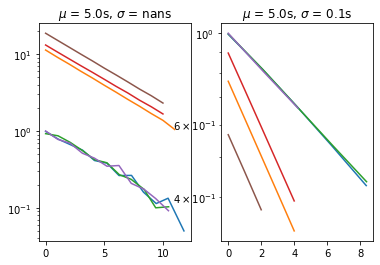

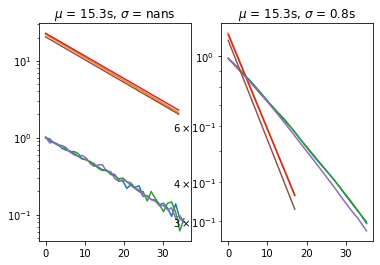

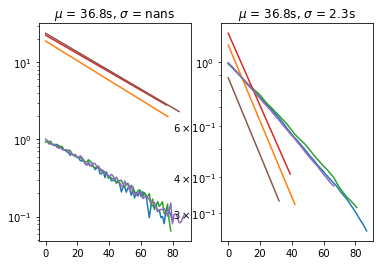

In [9]:
expt_set_dirs =  ["3mm", "6mm", "9mm"] #replace with your own directory names
lifetime = [5, 15.3, 36.8] #replace with the lifetimes you measured above
for i in range(3):
  expt_set_dir = expt_set_dirs[i]
  slope_lifetime = []
  ampsq_lifetime = []
  plt.figure()
  plt.subplot(1, 2, 1)
  for file in smallSlope[expt_set_dir]:
    time, slope, number = loadSlopeFile(file, lifetime[i]*((4/3)**3))
    #CODE11: three lines of code that do an exponential fit, semilog plot (with slope scaled by 1/a), and add lifetime to list
    a,b,*_ = fitExponential(time-time[0], slope)  
    plt.semilogy(time-time[0],slope/a,*_)
    slope_lifetime.append(-1/b)
  #CODE12: two lines of code that calculate mean and standard deviation
  mu = statistics.mean(slope_lifetime)
  sigma = np.std(ampsq_lifetime)
  plt.title (r'$\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu, sigma))

  plt.subplot(1, 2, 2)
  for file in smallAmplitude[expt_set_dir]:
    time, amp, number = loadAmpltidueFile(file, lifetime[i]*((4/3)**3))
    #CODE12: three lines of code that do an exponential fit, semilog plot (with amplitude squared scaled by 1/a), and add lifetime to list
    a,b,*_ = fitExponential(time-time[0], amp)
    plt.semilogy(time-time[0],amp/a,*_)  
    ampsq_lifetime.append(-1/b)
  #CODE13: two lines of code that calculate mean and standard deviation
  mu = statistics.mean(slope_lifetime)
  sigma = np.std(ampsq_lifetime, ddof=1)
  plt.title (r'$\mu$ = {:.1f}s, $\sigma$ = {:.1f}s'.format(mu, sigma))

##Questions - answer below

1. Based on these graphs, should you use slope or amplitude squared to measure the lifetime of the bob?
**amp squared since it gives you less noisey and more accuarte data.**
2. What is it called when a measurement has errors that aren't random? Do you think either the slope or amplitude measurements have these kinds of errors?
**they are called experimetal errors. I think boths the slope and amp have these errors, but the slope has them much more signifigantly**

#Lifetime vs. separation

OK, now let's look at the whole data set. We want to find a relation between the separation and the lifetime. 

We need to do the following:
1. Make a list of all the directories we want analyzed
1. Define a numerical value of the height for each directory. 
1. Loop over all the directories. For each directory
  1. Calculate the lifetime from each experiment. I'm using slope, because I think it was more reliable in my data set. You can use amplitude squared if you think that's better. Justify your choice. 
  1. Find the mean and standard deviation of these lifetimes. 
  1. Calculate the standard error of the mean as the standard deviation over the square root of the number of measurements
1. Make an [error bar plot](https://physics.nyu.edu/pine/pymanual/html/chap5/chap5_plot.html#error-bars) of lifetime vs. separation. My error bars were small enough they were hard to see. How about yours?

Text(0, 0.5, 'lifetime(s)')

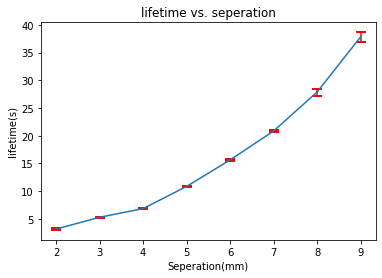

In [10]:
import math
import statistics
sml_dir = ("2mm", "3mm", "4mm", "5mm", "6mm", "7mm", "8mm", "9mm") #replace with your directory names
sml_h = np.array((2,3,4,5,6,7,8,9),'float') #replace with your distances
maxtime = [-1] * len(sml_dir) #[-1, -1, -1, -1, -1, -1, -1, -1, -1] - you can explicitly define times for some or all directories if the default of 1.5 lifetimes isn't good for you

#initialize numpy arrays
sml_tau = sml_h*0.;
sml_tau_sigma = sml_h*0.;
sml_tau_sem = sml_h*0.;



for i in range(len(sml_dir)):
    key = sml_dir[i]
    lifetime = []
    #if maxtime isn't defined, then calculate lifetime and use 1.5 lifetimes as the max time
    if (maxtime[i] <= 0):
      for file in smallSlope[key]:
        time, slope, number = loadSlopeFile(file)
        if (len(time) > 4):
          a,b,*_ = fitExponential(time-time[0], slope)
          lifetime.append(-1/b)
#CODE 14: two lines, calculate exponential fit of slope to time - time[0] and append -1/b to lifetime list
      initial_lifetime = np.median(lifetime)
      maxtime[i] = initial_lifetime*1.5
      lifetime = []

    for file in smallSlope[key]:  
      time, slope, number = loadSlopeFile(file, maxTime = maxtime[i])
      if (len(time) > 4):
        a,b,*_ = fitExponential(time-time[0], slope)
        lifetime.append(-1/b)
    sml_tau[i] = statistics.mean(lifetime) #CODE 15: calculate mean of lifetime list
    sml_tau_sigma[i] = np.std(lifetime,ddof=1)
    sml_tau_sem[i] = (sml_tau_sigma[i]/len(lifetime)**.5)#CODE 16: lg_tau_sigma[i] / square root of the number of elements in the lifetime list
    #CODE17: use plt.errorbar to makea plot of lg_tau vs. tg_h with yerr of lg_tau_sem
plt.errorbar(sml_h, sml_tau, yerr = sml_tau_sem, ms=10, mew = 2, ecolor ='r', capsize =5)
#CODE18: add title (lifetime vs. separation) xlabel (separation(mm)) and ylabel (lifetime(s)). hint add a ; to the end of the last line to eliminate the annoying text message in the output
plt.title('lifetime vs. seperation')
plt.xlabel('Seperation(mm)')
plt.ylabel('lifetime(s)')

##Fit lifetime vs. height to a power law

if $\tau = a h^b$, then $\log(\tau) = b \log(h) + \log(a)$ 

in other words, a log-log graph will look like a straight line

use the plt.loglog command to plot lifetime (tau) vs separation (lg_h)

use 'bo-' (blue circles connectd by lines) for the line type




Text(0, 0.5, 'lifetime(s)')

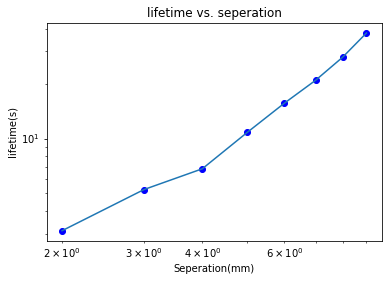

In [11]:
#CODE 19: log-log plot of lifetime vs. separation
plt.loglog(sml_h, sml_tau, 'bo')
plt.loglog(sml_h, sml_tau)
plt.title('lifetime vs. seperation')
plt.xlabel('Seperation(mm)')
plt.ylabel('lifetime(s)')

##Fit lifetime vs. height to a power law, take 2

If your data is like mine, this doesn't look like a very straight line. The problem is that the real form is probably something like 

$\tau = a (h + h_0)^b$, and $\log(\tau) = b \log(h+h_0) + \log(a)$ 

where $h_0$ is some offset due to the thickness of the magnet and the aluminum plate. The magnet is 3/16" thick and the plate is 1/8" thick. Together, that's about 8mm of thickness, and the distance between their centers is therefore 4 mm. 

try putting in an offset of 4 mm (plot tau vs. h + 4) and see if it looks more like a straight line. hint, you will have to convert lg_h to a numpy array before you can add 4. 

Text(0, 0.5, 'lifetime(s)')

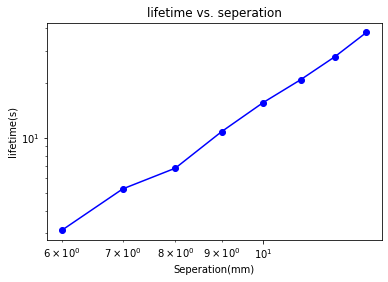

In [12]:
#CODE 20: log-log plot of lifetime vs. separation + 4 mm
a=np.array(sml_h)
b=a+4
plt.loglog(b, sml_tau, 'bo')
plt.loglog(b, sml_tau, 'b')
plt.title('lifetime vs. seperation')
plt.xlabel('Seperation(mm)')
plt.ylabel('lifetime(s)')

##Well that looks good, but....

Now do the same things for offsets of 3 and 5 mm... Do you still see a straight line?

Text(0, 0.5, 'lifetime(s)')

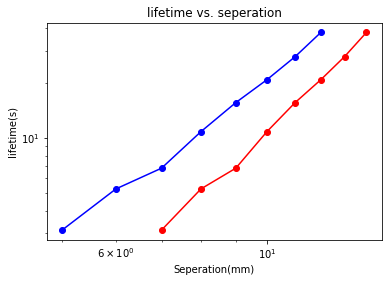

In [13]:
#CODE 21: two lines: log-log plots of lifetime vs. separation + 3mm and + 5mm, one in red and one in blue
a=np.array(sml_h)
b=a+3
plt.loglog(b, sml_tau, 'bo')
plt.loglog(b, sml_tau, "b")
c=a+5
plt.loglog(c, sml_tau, 'ro')
plt.loglog(c, sml_tau, "r")
plt.title('lifetime vs. seperation')
plt.xlabel('Seperation(mm)')
plt.ylabel('lifetime(s)')


## Use the residuals to find the most likely value of the separation

The residuals (the difference of the measured value from the fit value) can be used to tell you the quality of a fit. Assuming each measurement has equal error, the best fit is the one that minimizes the sum of the square of the residuals

minimize $\sum_h(\tau(h) - \tau_{fit}(h))^2$

below, I've written a function that calculates the sum of the squared residuals for a power law fit, given some offset $h_0$.  Then I make a graph of this sum vs. my guess of $h_0$ 

I need you to write a few lines for me


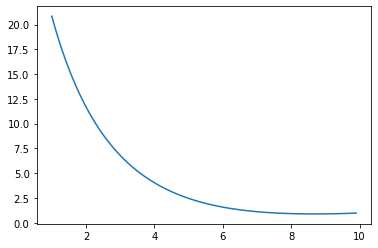

In [14]:
def powerLawResidualSqSum(h, tau, h0):
  x = np.log(h + h0)
  y = np.log(tau)
  m,b,yfit = fitLine(x,y)
  tau_fit = np.exp(yfit)
  return sum(((tau-tau_fit)**2))
#CODE 22: sum of tau - tau_fit squared 

offset = np.arange(1,10,.1)
residsq = offset*0
for i in range(len(offset)):
  residsq[i] = powerLawResidualSqSum(sml_h, sml_tau, offset[i]) #CODE 23: use the function above to calculate the residual for lg_h, lg_tau and offset[i] 
plt.plot(offset, residsq);

By eye, you might be able to find the best guess for h0, but we can actually ask python to find the true minimum, using scipy.optimize. We'll worry about how this works later, but for now just run the code block below to find the minimum 

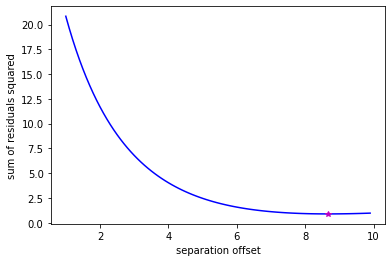

In [15]:
res = scipy.optimize.minimize(lambda h : powerLawResidualSqSum(sml_h, sml_tau,h), 5)
h0 = res.x[0]
rsq = res.fun
plt.plot(offset, residsq, 'b-', h0, rsq, 'm*')
plt.xlabel ('separation offset')
plt.ylabel ('sum of residuals squared');

Finally, using the best value of the separation (h0) you calculated above, find the power law exponent and plot the data and the fit for lifetime vs. separation together. 

Then, in another figure, plot the residuals with the error bars of the measurements.. x:lg_h, y: lg_tau - $\tau_{fit}$, error bars: lg_tau_sem



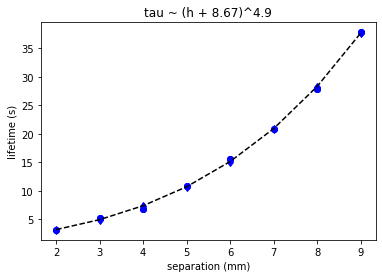

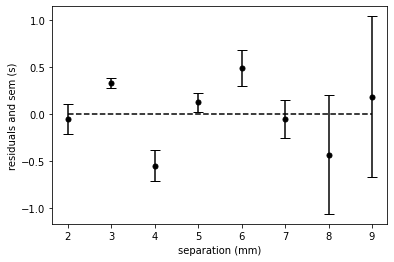

In [16]:
hmin =h0
x = np.log(np.array(sml_h) + hmin)
y = np.log(sml_tau)

m,b,yfit = fitLine(x,y) #CODE 24: fit to a line y = mx + b
sml_taufit = np.exp(yfit)

#CODE 25: plot lg_tau vs. lg_h with blue circles and lg_taufit vs lg_h with a black dashed line
plt.plot(sml_h, sml_tau, 'bo') 
plt.plot(sml_h, sml_taufit, 'bd')
plt.plot(sml_h, sml_tau,  'bo', sml_h, np.exp(yfit), 'k--')
plt.xlabel('separation (mm)')
plt.ylabel('lifetime (s)')
plt.title('tau ~ (h + {:.2f})^{:.1f}'.format(hmin, m) );

plt.figure()
#CODE 26: error bar plot of lg_tau-lg_taufit vs. lg_h, yerr = lg_tau_sem
plt.errorbar(sml_h, (sml_tau-sml_taufit), yerr=sml_tau_sem, fmt="o", mfc="black", mec="black", ms=5, mew = 1, ecolor ='black', capsize =5)
plt.xlabel('separation (mm)')
plt.ylabel('residuals and sem (s)')

#Add a black dashed line across the x-axis by plotting lg_h*0 vs lg_h. 
plt.plot(sml_h, sml_h*0, 'k--');

#Small bob time!

Please reuse the analysis steps you did above to make a plot of lifetime vs separation for the small bob, along with a power law fit.

Then make two additional plots
1. Plot lifetime vs. separation for the large and small bobs on the same graph. Use blue circles for the large bob and red circles for the small bob. Add a legend to the plot.
2. Make the same plot, but this time, multiply the small bob lifetime by (4/3)^3. Does this analysis support the relation $\tau \propto m_{bob}$?



#A few more questions

The total energy of the bob is $E = \frac{1}{2} m (A * 2\pi / T)^2$, where $m$ is the mass, $A$ is the amplitude, and $T$ is the period. The rate of energy loss is $-\frac{dE}{dt} = E/\tau$, where $\tau$ is the lifetime. For the large bob, please calculate the following, to 1 significant figure (e.g. 10 J, not 10.231 J)
1. The total energy when A = 10 cm
1. The total energy when A = 1 cm
1. The rate of energy loss for a separation of 2 mm, when A = 10 cm and A = 1 cm
1. The rate of energy loss for a separation of 10 mm (or whatever your maximum separation was), when A = 10 cm and A = 1 cm
